In [1]:
import os
import random

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision import datasets

device = torch.device('cuda:1')
# torch.cuda.set_device(7)

/tmp/ipykernel_162929/4134392719.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# # used to unzip files in server
# from zipfile import ZipFile
# # specifying the zip file name 
# file_name = "data_processed.zip"
  
# # opening the zip file in READ mode 
# with ZipFile(file_name, 'r') as zip: 
#     # printing all the contents of the zip file 
#     zip.printdir() 
  
#     # extracting all the files 
#     print('Extracting all the files now...') 
#     zip.extractall() 
#     print('Done!') 

In [3]:
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)
torch.backends.cudnn.deterministic = True

In [4]:
def extract_and_split(data_path, ignore_classes=[]):
        x_train = []
        x_test = []
        y_train = []
        y_test = []
        subfolders = [f.path for f in os.scandir(data_path) if f.is_dir()]
        
        for subfolder in subfolders:
            class_name = subfolder.split('/')[-1]
            if class_name in ignore_classes:
                continue

            files_in_subfolder = [f.path for f in os.scandir(subfolder) if f.is_file() and (f.name.endswith('.jpg') or f.name.endswith('.png'))]

            train_files, test_files = train_test_split(files_in_subfolder, train_size=0.8)
            x_train += train_files
            x_test += test_files
            y_train += [class_name] * len(train_files)
            y_test += [class_name] * len(test_files)

        return x_train, x_test, y_train, y_test

In [5]:
x_train1, x_test1, y_train1, y_test1 = extract_and_split("./dataset/", ignore_classes=[])
x_train2, x_test2, y_train2, y_test2 = extract_and_split('./data_processed/', ignore_classes=[])
x_train = x_train1 + x_train2
y_train = y_train1 + y_train2
x_test = x_test1 + x_test2
y_test = y_test1 + y_test2

In [6]:
# Map class names to integers
all_classes = np.unique(y_train + y_test)
mapping = {class_name.item(): idx for idx, class_name in enumerate(all_classes)}
rev_mapping = {idx: class_name for class_name, idx in mapping.items()}

y_train = torch.tensor([mapping[class_name] for class_name in y_train])
y_test = torch.tensor([mapping[class_name] for class_name in y_test])

In [7]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, img_list, labels, transforms):
        super(MyDataset, self).__init__()
        self.img_list = img_list
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img = self.img_list[idx]
        img = Image.open(img).convert('L')
        return self.transforms(img), self.labels[idx]

(155, 135)


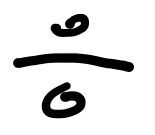

In [8]:
img_path = x_train[456]
image = Image.open(img_path)
print(image.size)
image

In [9]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
train_dataset = MyDataset(x_train, y_train, transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = MyDataset(x_test, y_test, transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [10]:
num_classes = len(np.unique(y_train))

In [11]:
input_channels = 1
conv_layers = nn.Sequential(
    nn.Conv2d(input_channels, 16, 3, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 32, 3, padding=1),
    nn.ReLU(),
    nn.Conv2d(32, 64, 3, padding=1),
    nn.ReLU()
)

# Calculate the size of the output of the conv_layers by doing one forward pass
dummy_input = torch.randn(1, input_channels, 128, 128)
output = conv_layers(dummy_input)
conv_out = output.shape[1] * output.shape[2] * output.shape[3]

model = nn.Sequential(
    conv_layers,
    nn.Flatten(),
    nn.Linear(conv_out, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, num_classes)
)

In [12]:
epochs = 2
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [13]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
device = torch.device('cuda:0')
model.to(device)

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
  )
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=1048576, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=128, bias=True)
  (5): ReLU()
  (6): Linear(in_features=128, out_features=85, bias=True)
)

In [15]:
# load existing model, skip the training block to go straight to testing, remember to ensure that the structure match the .txt file
# model.load_state_dict(torch.load("data_processed_model8774.pth"))
# model.eval()

In [16]:
for epoch in range(epochs):
    # Training Phase
    model.train()
    total_train_loss = 0
    total_train_correct = 0
    total_test_correct = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

        # Convert outputs probabilities to predicted class
        _, predicted = torch.max(outputs, 1)
        
        # Calculate correct predictions
        total_train_correct += (predicted == labels).sum().item()

    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), torch.tensor(labels).to(device)

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = loss_fn(outputs, labels)

        # Convert outputs probabilities to predicted class
        _, predicted = torch.max(outputs, 1)
        
        # Calculate correct predictions
        total_test_correct += (predicted == labels).sum().item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = total_train_correct / len(train_loader.dataset)
    test_accuracy = total_test_correct / len(test_loader.dataset)

    # Print epoch summary
    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}')

/tmp/ipykernel_162929/2846701550.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs, labels = inputs.to(device), torch.tensor(labels).to(device)


Epoch [1/2], Train Loss: 0.9382, Train Accuracy: 0.7615, Test Accuracy: 0.8530
Epoch [2/2], Train Loss: 0.3395, Train Accuracy: 0.8995, Test Accuracy: 0.8630


In [17]:
model.eval()

total_loss = 0
total_correct = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), torch.tensor(labels).to(device)

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = loss_fn(outputs, labels)
        total_loss += loss.item()

        # Convert outputs probabilities to predicted class
        _, predicted = torch.max(outputs, 1)
        
        # Calculate correct predictions
        total_correct += (predicted == labels).sum().item()

avg_loss = total_loss / len(test_loader)
accuracy = total_correct / len(test_loader.dataset)

print(f'Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}')

/tmp/ipykernel_162929/1784268762.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs, labels = inputs.to(device), torch.tensor(labels).to(device)


Test Loss: 0.4806, Test Accuracy: 0.8630


Predicted: sqrt, Actual: sqrt


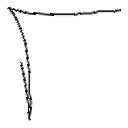

In [18]:
# Get random test image
img, label = test_dataset[random.randint(0, len(test_dataset))]

pred = model(img.unsqueeze(0).to(device))
_, pred = torch.max(pred, 1)
print(f"Predicted: {rev_mapping[pred.item()]}, Actual: {rev_mapping[label.item()]}")

# convert img to PIL image
img = img.squeeze(0)
img = transforms.ToPILImage()(img)
img

In [20]:
# save model to file
torch.save(model.state_dict(), "both_dataset_model8630.pth")